In [ ]:
import openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
import re
import spacy
import spacy.cli
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Download the English language model, that includes tokenization, part-of-speech tagging, and lemmatization
spacy.cli.download("en_core_web_sm")

nltk.download('punkt')

# Lab 2 - Unsupervised learning and text classification

## Part 1 - EDA, Clustering and Dimensionality reduction

### Exercise 1 Exploratory Data Analysis (EDA)

In [2]:
dataset = openml.datasets.get_dataset(43582)
df, *_ = dataset.get_data()
df.drop(columns=["Outcome"], inplace=True) # We chose to drop the Outcome column
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


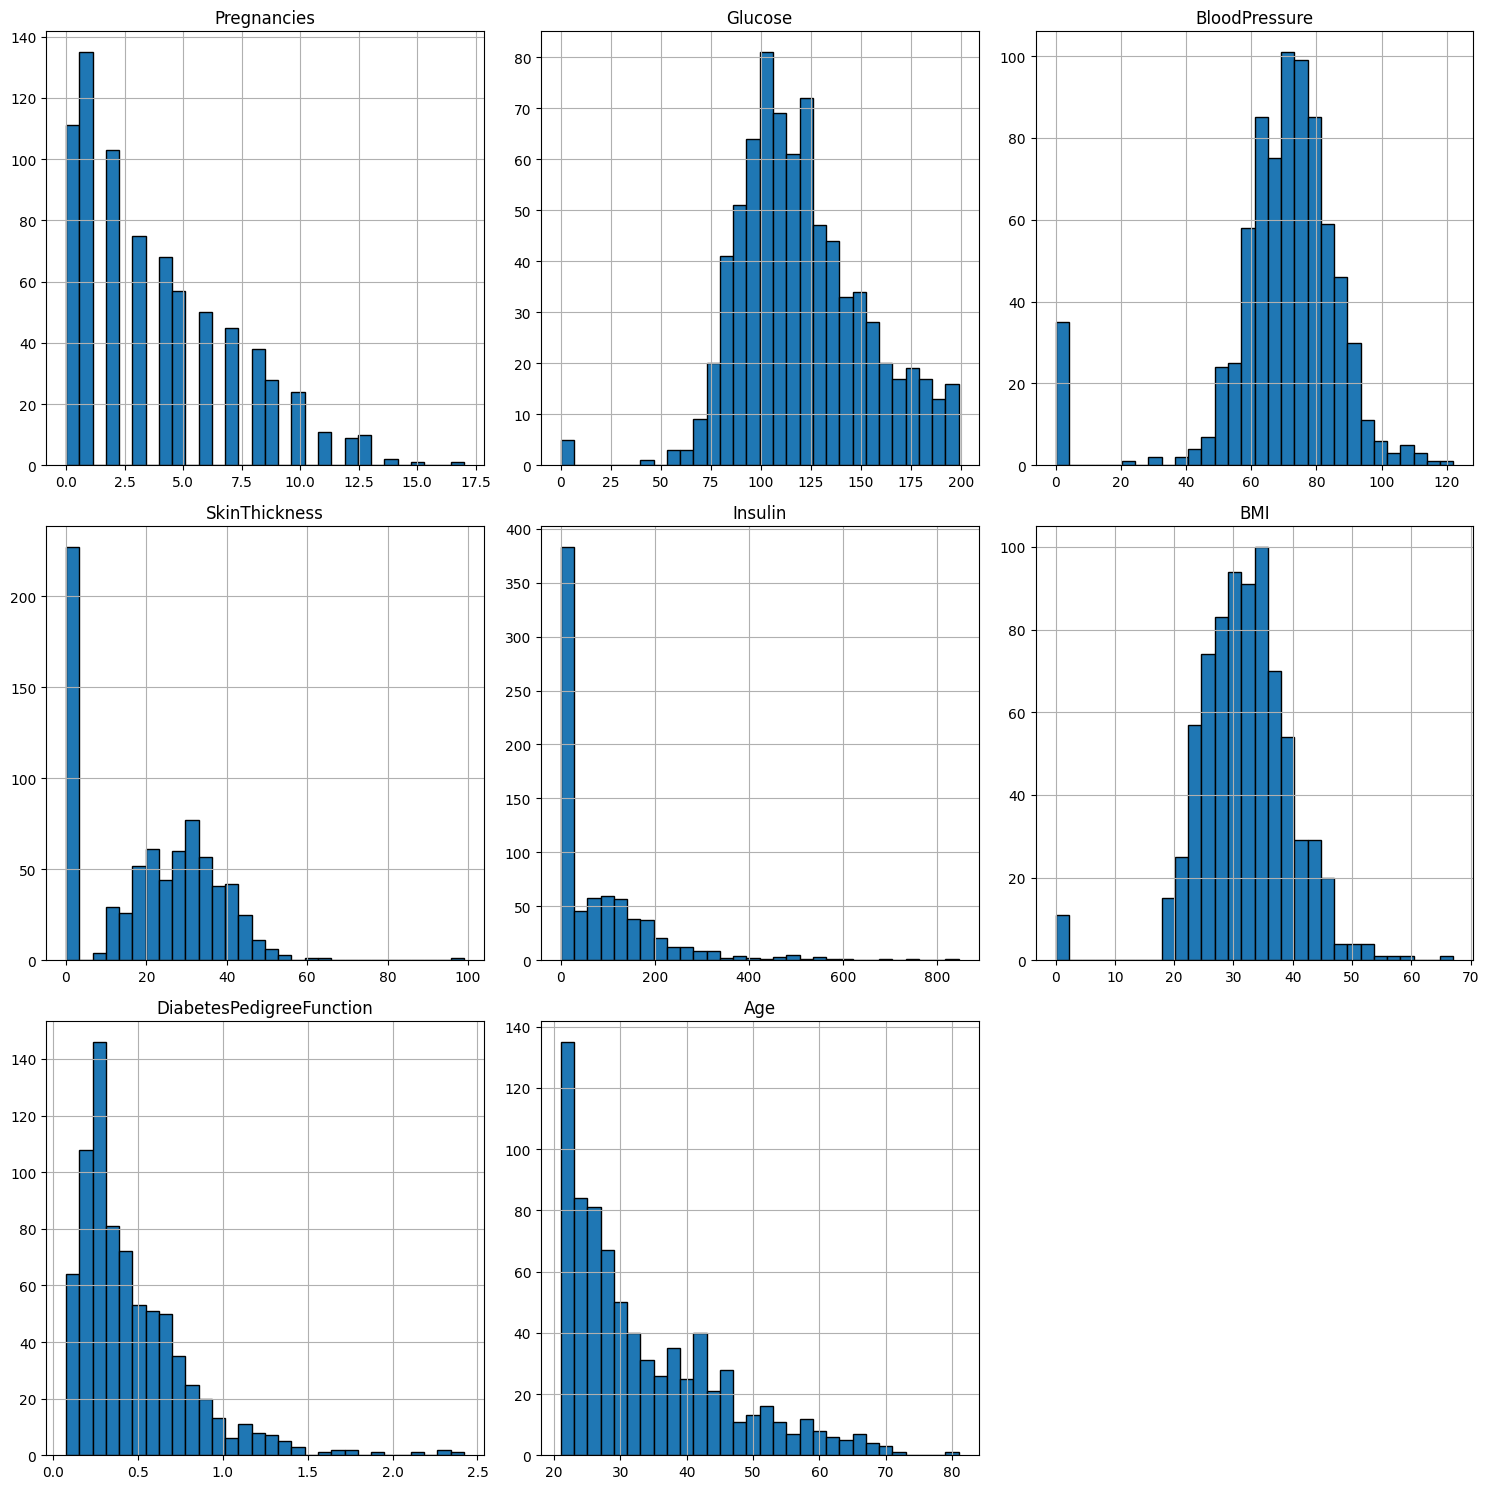

In [4]:
n = len(df.columns)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(df.columns):
    df[feature].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [5]:
print("---- Missing values ---- \n", df.isnull().sum())
print("\n\n---- Zeros ---- \n", (df == 0).sum())

---- Missing values ---- 
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


---- Zeros ---- 
 Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


There are no missing values. However, there are some anomalous values:
- Glucose
- Blood Pressure
- Skin Thickness
- Insulin
- BMI

These values cannot be zero.

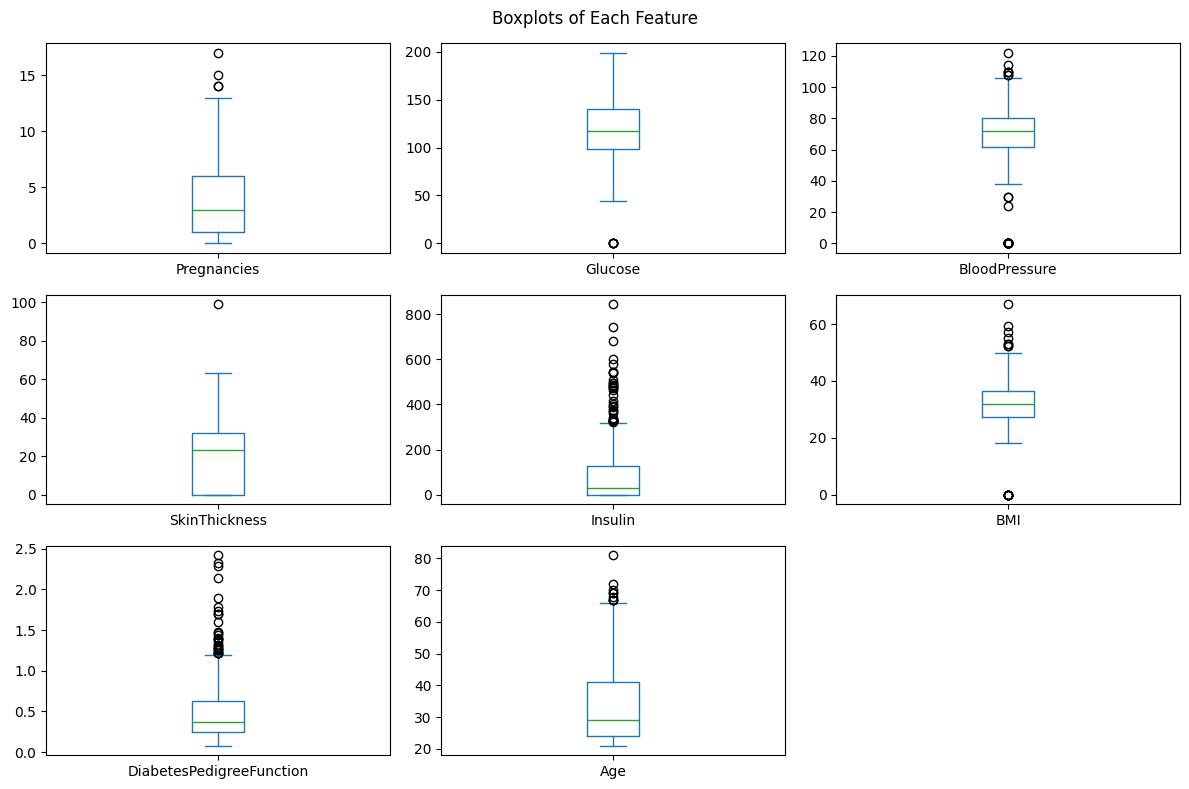

In [6]:
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(12, 8), sharex=False, sharey=False)
plt.suptitle('Boxplots of Each Feature')
plt.tight_layout()
plt.show()

To avoid data leakage, we only standardize the training set

In [7]:
# We split the dataset
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

numeric_cols = df.select_dtypes(include='number').columns
X_train_numeric = X_train[numeric_cols]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)

X_train_scaled_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,-0.526397,-1.151398,-3.752683,-1.322774,-0.701206,-4.135256,-0.490735,-1.035940
618,1.588046,-0.276643,0.680345,0.233505,-0.701206,-0.489169,2.415030,1.487101
346,-0.828460,0.566871,-1.265862,-0.090720,0.013448,-0.424522,0.549161,-0.948939
294,-1.130523,1.254179,-1.049617,-1.322774,-0.701206,-1.303720,-0.639291,2.792122
231,0.681856,0.410665,0.572222,1.076490,2.484601,1.838121,-0.686829,1.139095
...,...,...,...,...,...,...,...,...
71,0.379793,0.566871,-0.292759,0.946800,0.504235,-0.437451,-0.172824,-0.600933
106,-0.828460,-0.776503,2.842797,-1.322774,-0.701206,-1.239073,-0.778934,-0.513932
270,1.890109,-0.620297,0.896590,1.076490,-0.701206,1.760544,1.981245,0.443084
435,-1.130523,0.629354,-3.752683,-1.322774,-0.701206,1.346804,-0.784877,-0.339929


### Exercise 2 - K-means Clustering

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled_df)

cluster_labels = kmeans.labels_

# Add the cluster labels to the scaled DataFrame
X_train_scaled_df['cluster'] = cluster_labels

X_train_scaled_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,cluster
60,-0.526397,-1.151398,-3.752683,-1.322774,-0.701206,-4.135256,-0.490735,-1.035940,1
618,1.588046,-0.276643,0.680345,0.233505,-0.701206,-0.489169,2.415030,1.487101,0
346,-0.828460,0.566871,-1.265862,-0.090720,0.013448,-0.424522,0.549161,-0.948939,1
294,-1.130523,1.254179,-1.049617,-1.322774,-0.701206,-1.303720,-0.639291,2.792122,1
231,0.681856,0.410665,0.572222,1.076490,2.484601,1.838121,-0.686829,1.139095,0
...,...,...,...,...,...,...,...,...,...
71,0.379793,0.566871,-0.292759,0.946800,0.504235,-0.437451,-0.172824,-0.600933,0
106,-0.828460,-0.776503,2.842797,-1.322774,-0.701206,-1.239073,-0.778934,-0.513932,1
270,1.890109,-0.620297,0.896590,1.076490,-0.701206,1.760544,1.981245,0.443084,0
435,-1.130523,0.629354,-3.752683,-1.322774,-0.701206,1.346804,-0.784877,-0.339929,1


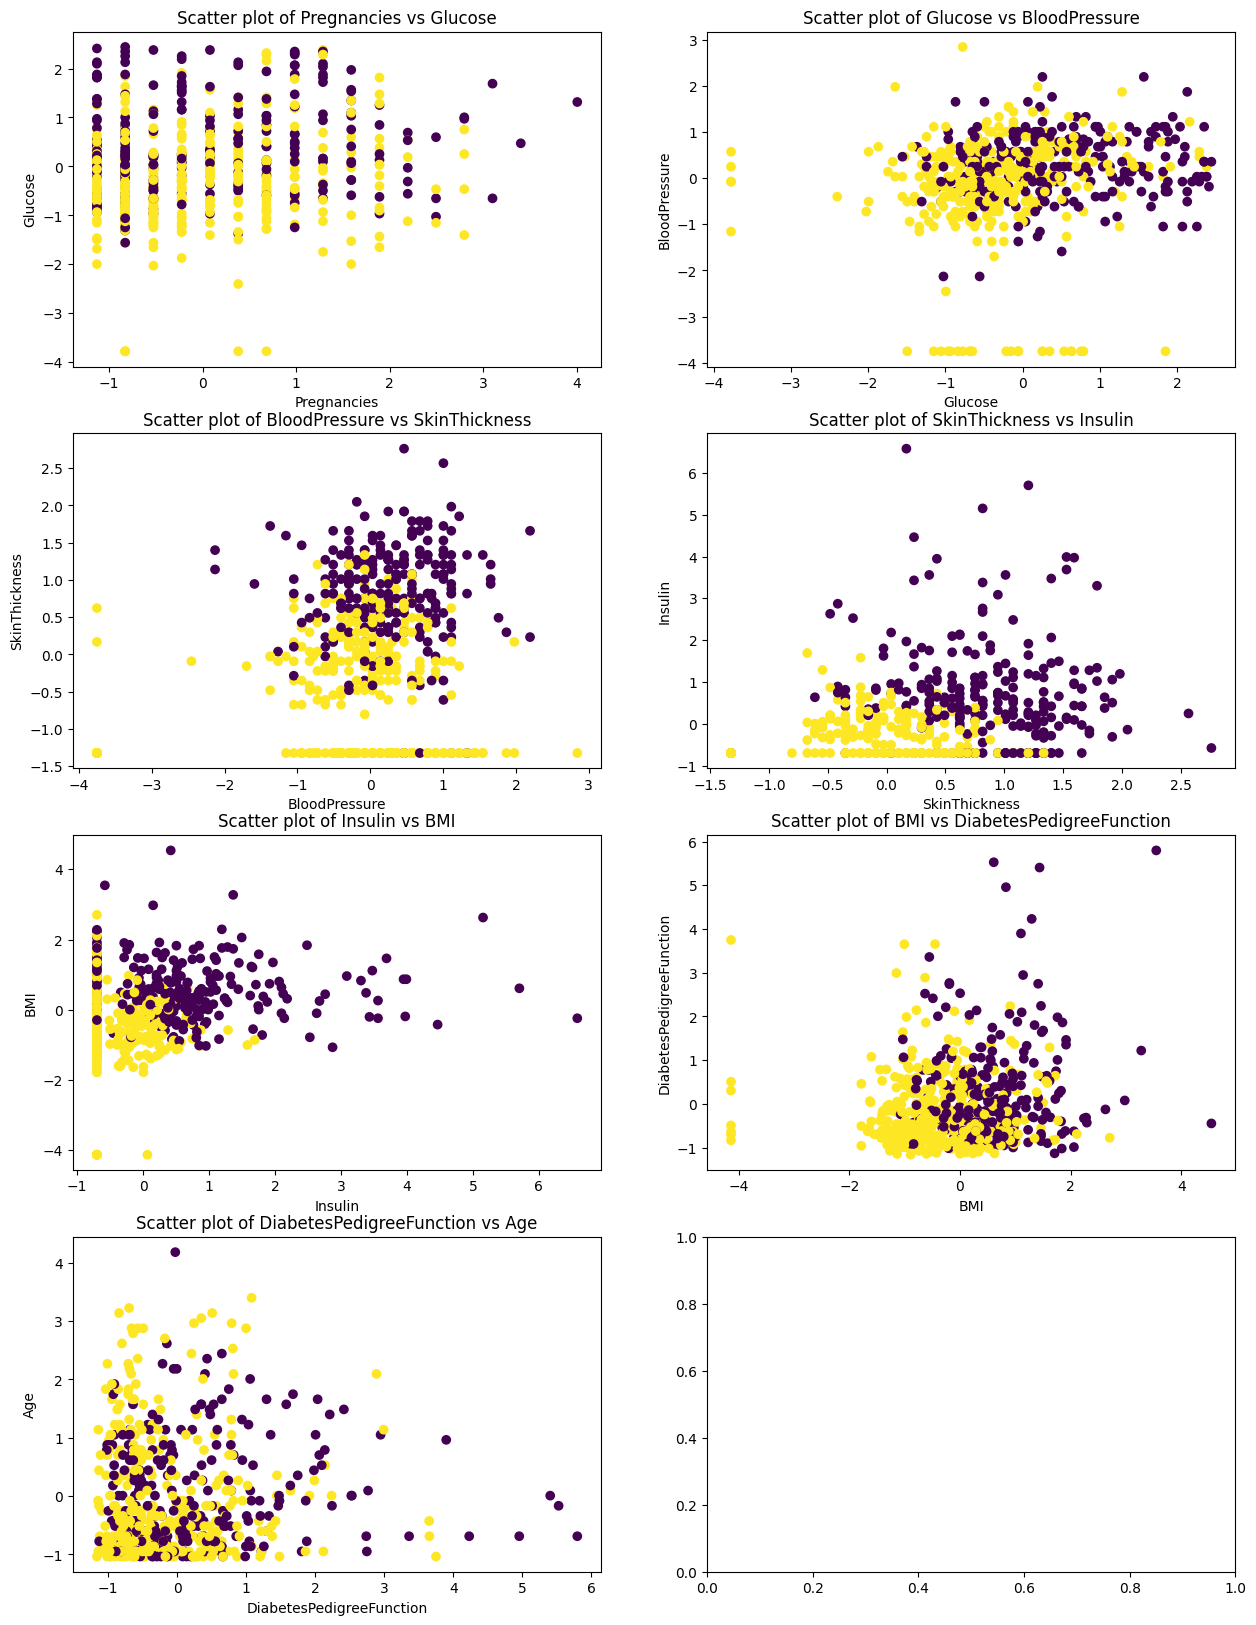

In [9]:
cols = 2
rows = (len(X_train_scaled_df.columns) + cols - 1) // cols - 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i in range(len(df.columns) - 1):
    axes[i // cols, i % cols].scatter(X_train_scaled_df[df.columns[i]], X_train_scaled_df[df.columns[i+1]], c=X_train_scaled_df['cluster'])
    axes[i // cols, i % cols].set_xlabel(df.columns[i])
    axes[i // cols, i % cols].set_ylabel(df.columns[i+1])
    axes[i // cols, i % cols].set_title(f'Scatter plot of {df.columns[i]} vs {df.columns[i+1]}')

As we can see, the clusters make no sense.
We even can't see delimiter on any plot.
This means that the provided data are not really separable into K groups (here 2). Some datas don't contain useful variance.

### Exercise 3 - PCA and Visualization

In [10]:
X = X_train_scaled_df.drop(columns='cluster', errors='ignore')

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X.index)

X_pca_df

,PC1,PC2
60,-4.941712,-0.525098
618,0.915510,1.773579
346,-0.634276,-1.153893
294,-1.103808,2.031867
231,2.900033,0.060172
...,...,...
71,0.445656,-0.499450
106,-1.157047,0.512625
270,1.928881,0.706114
435,-1.831314,-0.847250


In [11]:
variance_ratio = pca.explained_variance_ratio_
for i, ratio in enumerate(variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")

PC1: 0.2553
PC2: 0.2207


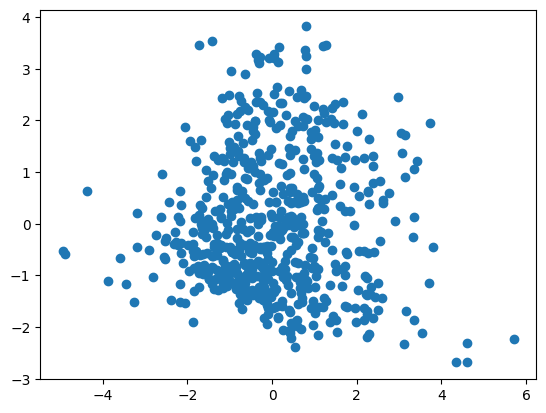

In [12]:
plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'])

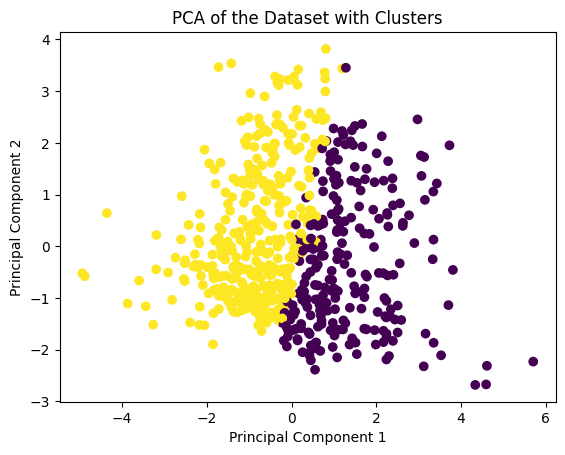

In [13]:
# We add the cluster from the previous kmeans (k=2)
if 'cluster' in X_train_scaled_df.columns:
    X_pca_df['cluster'] = X_train_scaled_df['cluster']

plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=X_pca_df['cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Dataset with Clusters')
plt.show()

In [14]:
features = X_train_scaled_df.columns[:-1] # Exclude the cluster column

pc_loadings = pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2'])

pc_loadings

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
PC1,0.167939,0.403316,0.359404,0.420911,0.441016,0.443144,0.264893,0.204342
PC2,0.568906,0.181750,0.180575,-0.368467,-0.254301,-0.139290,-0.114625,0.614596


In [15]:
pc1_top_features = pc_loadings.loc['PC1'].abs().sort_values(ascending=False)
pc2_top_features = pc_loadings.loc['PC2'].abs().sort_values(ascending=False)

print("Top features contributing to PC1:")
print(pc1_top_features.head())

print("\nTop features contributing to PC2:")
print(pc2_top_features.head())

Top features contributing to PC1:
BMI              0.443144
Insulin          0.441016
SkinThickness    0.420911
Glucose          0.403316
BloodPressure    0.359404
Name: PC1, dtype: float64

Top features contributing to PC2:
Age              0.614596
Pregnancies      0.568906
SkinThickness    0.368467
Insulin          0.254301
Glucose          0.181750
Name: PC2, dtype: float64


## Part 2 - Text classification using Bag of Words, TF-IDF, Word2Vec and BERT embeddings 

### Exercise 1: Text Preprocessing

In [2]:
# Load the dataset using scikit-learn's fetch_20newsgroups() method
# And filter the dataset to keep only the records labeled with the computing-related categories:
# 1. comp.graphics
# 2. comp.os.ms-windows.misc
# 3. comp.sys.ibm.pc.hardware
# 4. comp.sys.mac.hardware
# 5. comp.windows.x

dataset2 = fetch_20newsgroups(subset='all', categories=[
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x'
])

target_names_dataset2 = dataset2.target_names
print(f"Target names: {target_names_dataset2}")

# Create a DataFrame with the text data and labels
df2 = pd.DataFrame({'text': dataset2.data, 'label': dataset2.target})

df2

Target names: ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x']


,text,label
0,From: u122743@twncu865.ncu.edu.tw\nSubject: QU...,0
1,From: miket@empros.com (Mike Tipton)\nSubject:...,1
2,From: mark@ocsmd.ocs.com (Mark Wilson)\nSubjec...,0
3,From: kiki@PROBLEM_WITH_INEWS_GATEWAY_FILE (Ke...,0
4,Organization: Queen's University at Kingston\n...,3
...,...,...
4886,From: changw@nmt.edu (willie* chang)\nSubject:...,3
4887,From: studner@rintintin.Colorado.EDU (STUDNER ...,2
4888,From: david@pop (David E. Smyth)\nSubject: Re:...,4
4889,From: NURDEN1@elaine.ee.und.ac.za (Dale Nurden...,2


In [3]:
# Preprocess the text:
# o Convert the text to lowercase.
# o Remove punctuation (use regular expressions).
# o Lemmatize the words using spaCy.

nlp = spacy.load("en_core_web_sm")

# Lower case and remove punctuation
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation using regex
    return text
df2["text"] = df2["text"].apply(preprocess_text)

with nlp.select_pipes(disable=["parser", "ner"]):  # We disable the parser and NER components, as we only need tokenization and lemmatization
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(df2["text"], batch_size=50, n_process=-1)):
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc]))
    df2["text"] = preprocessed_texts


df2


,text,label
0,from u122743twncu865ncuedutw \n subject questi...,0
1,from miketemproscom mike tipton \n subject cha...,1
2,from markocsmdocscom mark wilson \n subject re...,0
3,from kikiproblem_with_inews_gateway_file keith...,0
4,organization queen university at kingston \n f...,3
...,...,...
4886,from changwnmtedu willie chang \n subject what...,3
4887,from studnerrintintincoloradoedu studner rog...,2
4888,from davidpop david e smyth \n subject re r5 t...,4
4889,from nurden1elaineeeundacza dale nurden \n sub...,2


In [4]:
X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series
X_train, X_test, y_train, y_test = train_test_split(df2, df2["label"], test_size=0.2, random_state=42)

In this case, there will be no data leakage between the training and test dataset, because the preprocessing affects each row independently of other rows. 

In [5]:
# We create that dictionary to keep the result into an object (we will use it later)
results = {}

### Exercise 2 - Bag of Words (BoW)

In [20]:
vectorizer = CountVectorizer(stop_words='english') # We pass this parameter to the CountVectorizer to remove stop words

X = vectorizer.fit_transform(X_train['text'])

print(f"Unique words in the vocabulary: {vectorizer.get_feature_names_out()}")

Unique words in the vocabulary: ['00' '000' '0000' ... 'zztvtz8nt2h' 'zzzz' 'ªlt']


In [21]:
LR = LogisticRegression()
LR.fit(X, y_train)

LogisticRegression()

In [22]:
y_pred = LR.predict(vectorizer.transform(X_test['text']))

accuracy = accuracy_score(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred, average='weighted')

results['CountVectorizer'] = {'accuracy': accuracy, 'f1_score': f1_score_val}

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score_val:.4f}")

Accuracy: 0.8509
F1 Score: 0.8509


Using only accuracy for evaluating the performance of Bag of Words model, we can say that it performs relatively well, with 85 % of accuracy on the test dataset. 

### Exercise 3 - TF-IDF

In [23]:
vectorizer = TfidfVectorizer(stop_words='english')
X2 = vectorizer.fit_transform(X_train['text'])

X2

<3912x68335 sparse matrix of type '<class 'numpy.float64'>'
	with 326081 stored elements in Compressed Sparse Row format>

In [24]:
# Sum TF-IDF values for each term across all documents
tfidf_sum = X2.sum(axis=0)
tfidf_sum = np.asarray(tfidf_sum).flatten()

# Get feature names
terms = vectorizer.get_feature_names_out()

# Create DataFrame of terms and their total TF-IDF values
tfidf_df = pd.DataFrame({'term': terms, 'tfidf_sum': tfidf_sum})

tfidf_df.head(10) # Top 10 values

,term,tfidf_sum
0,00,2.346860
1,000,0.290990
2,0000,0.119959
3,000000,0.082640
4,00000000,0.140785
5,00000074,0.281570
6,000003,0.155450
7,000005102000,0.026912
8,00000510200001,0.011857
9,00000f,0.155450


In [25]:
LR2 = LogisticRegression()
LR2.fit(X2, y_train)

LogisticRegression()

In [26]:
y_pred = LR2.predict(vectorizer.transform(X_test['text']))

accuracy = accuracy_score(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred, average='weighted')

results['TF-IDF'] = {'accuracy': accuracy, 'f1_score': f1_score_val}

print(f"Accuracy with TF-IDF: {accuracy:.4f}")
print(f"F1 Score with TF-IDF: {f1_score_val:.4f}")

Accuracy with TF-IDF: 0.8703
F1 Score with TF-IDF: 0.8706


We notice a better accuracy after using the TF-IDF vectorizer. Indeed, here are the differences between Bag of Words and Term Frequency-Inverse Document Frequency:

Bag of Words:
- It counts how many times each word appears in the text
- It does not implement any feature which gives a weight for a word. Some words with no real meaning such as "the", "and" etc. will all be equally important.

TF-IDF:
- Same features with BoW
- But it implements a feature to know whether a word is common or not.

With these differences, we understand why TF-IDF would be more efficient.

### Exercise 4 - Word2vec

In [47]:
# Example with one long text column
sentences = X_train['text'].dropna().astype(str).tolist()

tokenized_sentences = [simple_preprocess(sentence) for sentence in sentences]

[tokenized_sentences[i][:10] for i in range(10)]

[['from',
  'eric',
  'bosco',
  'subject',
  'ctrlalt',
  'del',
  'lock',
  'the',
  'computer',
  'fafter'],
 ['from',
  'eric',
  'dittman',
  'subject',
  'question',
  'about',
  'irq',
  'and',
  'irq',
  'organization'],
 ['from',
  'kevin',
  'weinrich',
  'subject',
  'why',
  'do',
  'need',
  'xrdb',
  'when',
  'xdefault'],
 ['from',
  'jrezeoscom',
  'jim',
  'erickson',
  'subject',
  'bye',
  'organization',
  'zeos',
  'international',
  'ltd'],
 ['from',
  'christophe',
  'muller',
  'subject',
  're',
  'xv',
  'have',
  'escape',
  'organization',
  'simulog'],
 ['from',
  'kenneth',
  'robert',
  'ballou',
  'subject',
  're',
  'soundblaster',
  'irq',
  'and',
  'port'],
 ['from',
  'thumper',
  'subject',
  're',
  'new',
  'apple',
  'ergomouse',
  'replyto',
  'organization',
  'amos'],
 ['from',
  'tittleicsuciedu',
  'cindy',
  'tittle',
  'moore',
  'subject',
  're',
  'canon',
  'bj',
  'bubblejet'],
 ['from',
  'bruce',
  'powell',
  'subject',
  're',
 

In [48]:
model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,      # dimension of embedding vectors
    window=5,             # context window
    min_count=2,          # ignore words with frequency < 2
    workers=4,            # parallelism
    sg=1                  # 1 = skip-gram; 0 = CBOW
)

In [49]:
def document_vector(doc: list[str], model: Word2Vec):
    # Filter out words that are not in the Word2Vec vocabulary
    doc = [word for word in doc if word in model.wv]
    
    # If no words are found in the vocab, return a zero vector
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    
    # Average the word vectors
    return np.mean([model.wv[word] for word in doc], axis=0)

# Apply to all documents
document_vectors = np.array([document_vector(doc, model) for doc in tokenized_sentences])

document_vectors

array([[ 0.0370661 , -0.11344953, -0.10376903, ..., -0.43701422,
         0.12628278, -0.04494726],
       [ 0.11376702, -0.06794976, -0.02462361, ..., -0.33808318,
         0.18057281, -0.10766248],
       [ 0.0802414 , -0.05234888, -0.05652913, ..., -0.36043915,
         0.16813283, -0.03032674],
       ...,
       [ 0.10620709, -0.07868692,  0.03403566, ..., -0.26396224,
         0.20923519,  0.01811254],
       [ 0.18708421, -0.10653323, -0.00426685, ..., -0.30312112,
         0.18368372, -0.11023293],
       [ 0.06063455, -0.06574994, -0.06746171, ..., -0.38111174,
         0.17315634, -0.08719307]], dtype=float32)

In [50]:
LR3 = LogisticRegression(max_iter=500)
LR3.fit(document_vectors, y_train)

LogisticRegression(max_iter=500)

In [52]:
sentences_test = X_test['text'].dropna().astype(str).tolist()
tokenized_sentences_test = [simple_preprocess(sentence) for sentence in sentences_test]
document_vectors_test = np.array([document_vector(doc, model) for doc in tokenized_sentences_test])
y_pred = LR3.predict(document_vectors_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred, average='weighted')

results["Word2Vec"] = {'accuracy': accuracy, 'f1_score': f1_score_val}

print(f"Accuracy with Word2Vec: {accuracy:.4f}")
print(f"F1 Score with Word2Vec: {f1_score_val:.4f}")

Accuracy with Word2Vec: 0.7314
F1 Score with Word2Vec: 0.7315


The idea behind Word2Vec is actually to create a dictionary of words. It uses a neural network and outputs a probability distribution to know which word has the nearest meaning according to a context. The purpose is that words that appear in similar context will might be have the same meaning.

Despite all this complexity, Word2Vec performs significatively worse than TF-IDF and Bag of Words. Indeed, Word2Vec is specialized in word similarity detection, not classification. 

### Exercise 5 - Doc2Vec

In [53]:
# Vectorize the text using Doc2Vec embeddings.
# Use the Doc2Vec model from Gensim to train word embeddings.

# TaggedDocument format: (words as list, tag)
train_tagged = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(X_train['text'])]

model_d2v = Doc2Vec(min_count=2, workers=1, seed=42)
model_d2v.build_vocab(train_tagged)
model_d2v.train(train_tagged, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

# Get vectors for datasets
def vectorize_docs(model, docs):
    return np.array([model.infer_vector(doc.split()) for doc in docs])

X_train_vec = vectorize_docs(model_d2v, X_train['text'])

X_train_vec


array([[ 0.19258155,  0.03002936,  0.23303981, ...,  0.15447442,
        -0.1101384 ,  0.19967152],
       [-0.05790381,  0.26215443,  0.13895823, ...,  0.3726085 ,
         0.06021617, -0.04534646],
       [ 0.51641285, -0.05101871,  0.1495199 , ..., -0.00264198,
         0.17308305,  0.67985636],
       ...,
       [-0.01946859,  0.02224491,  0.15499091, ...,  0.08594682,
        -0.2748375 ,  0.0173458 ],
       [-0.01320561, -0.01446239,  0.09228875, ...,  0.28548595,
        -0.11668759,  0.05643788],
       [-0.0482233 , -0.42067394,  0.37887898, ...,  0.39583153,
        -1.4287057 ,  0.08934664]], dtype=float32)

In [54]:
# Train a model using Logistic Regression.

clf = LogisticRegression()
clf.fit(X_train_vec, y_train)

LogisticRegression()

In [55]:
y_pred = clf.predict(vectorize_docs(model_d2v, X_test['text']))

accuracy = accuracy_score(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred, average='weighted')

results["Doc2Vec"] = {'accuracy': accuracy, 'f1_score': f1_score_val}

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score_val:.4f}")

Test Accuracy: 0.7140
Test F1 Score: 0.7132


As the name suggests, Doc2Vec is designed to work with documents rather than just individual words. The algorithm assigns a unique vector to each document and learns to update these vectors during training. 
The goal is to learn document embeddings that capture the semantic meaning of the entire document. This allows us to compare documents by measuring the similarity between their vector representations - helping us identify which documents are close in meaning or topic.

Like Word2Vec, Doc2Vec is unsupervised and is not optimized for classification, hence why it loses to TF-IDF and Bag of Words. 

### Exercise 6 - BERT Embeddings

In [69]:
tokenizer: BertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model: BertModel = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    with torch.no_grad(): # Disable gradient calculation because we are not training the model
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512) # Convert the text into tokens that BERT can understand, with truncation and padding
        outputs = model(**inputs) # We pass the tokens to the BERT model (created above)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # Mean pooling
        attention_mask: torch.Tensor = inputs['attention_mask'] # We need to ignore the padding tokens and keep the real tokens
        mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float() # Reshape the attention mask to match the last hidden state (we are going to multiply them)
        masked_embeddings = last_hidden_state * mask # We multiply the last hidden state by the mask to remove the padding tokens
        summed = torch.sum(masked_embeddings, 1) # Sum the embeddings (we will compute the mean of the embeddings)
        counts = torch.clamp(mask.sum(1), min=1e-9) # We need to avoid division by zero
        mean_pooled = summed / counts # Compute the mean of the embeddings
        return mean_pooled.squeeze().numpy()


documents = X_train['text'].dropna().tolist()
bert_embeddings = [get_bert_embedding(doc) for doc in tqdm(documents)]

  0%|          | 3/3912 [01:30<24:31:45, 22.59s/it]

KeyboardInterrupt: 

In [63]:
LR4 = LogisticRegression(max_iter=1000)
LR4.fit(bert_embeddings, y_train)

LogisticRegression(max_iter=1000)

In [137]:
documents_test = X_test['text'].dropna().tolist()
bert_embeddings_test = [get_bert_embedding(doc) for doc in tqdm(documents_test)]

In [65]:
y_pred = LR4.predict(bert_embeddings_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred, average='weighted')
results["BERT"] = {'accuracy': accuracy, 'f1_score': f1_score_val}

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score_val:.4f}")

Accuracy: 0.7232
F1 Score: 0.7234


The meaning behind Bert is that it will create a vector for each word. This means that "blue car" and "red car" will be a different embedding. We can understand more the context. It's not because there is the same word that the meaning is the same. Therefore, BERT's contextual embeddings better represent the text than the other vectorizers. 

Even if the vectorisation time with Bert is computationaly more complex than with the other vectorizers, the model still performs mediocrely. It looks like the base model is inefficient at classifing our documents, as SentenceTransformers with "all-MiniLM-L6-v2" model (instead of Transformers with "bert-base-uncased") gives us 80.18 % of accuracy for only 15s of vectorization time. 

### Summary - Comparison of Models and Vectorization Techniques

In [39]:
pd_result = pd.DataFrame.from_dict(results, orient='index')

pd_result

,accuracy,f1_score
CountVectorizer,0.850868,0.850912
TF-IDF,0.870276,0.870600
Word2Vec,0.730337,0.730476
Doc2Vec,0.713994,0.713159
BERT,0.705822,0.705158


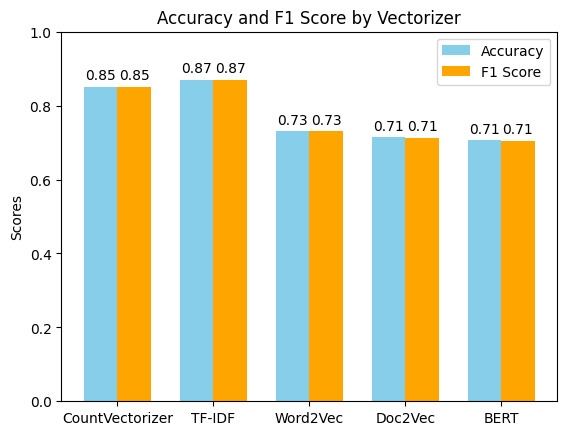

In [40]:
labels = pd_result.index.tolist()
accuracy = pd_result['accuracy'].values
f1_scores = pd_result['f1_score'].values

x = np.arange(len(labels))  # label locations
width = 0.35 

fig, ax = plt.subplots()

# Plot bars
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='orange')

# Labels and title
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score by Vectorizer')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1)
plt.show()


The best performers are 